In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from pathlib import Path

# ===== CONFIGURATION =====
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 30
DATASET_PATH = "/kaggle/input/tomato/train"  # Change this

# ===== 1. PRE-FILTER DATASET BEFORE LOADING =====
def validate_and_filter_images(dataset_path):
    """Remove corrupted images before training"""
    from PIL import Image
    
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    removed = 0
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            filepath = os.path.join(root, file)
            ext = os.path.splitext(file)[1].lower()
            
            # Remove invalid extensions
            if ext not in valid_extensions:
                try:
                    os.remove(filepath)
                    removed += 1
                except:
                    pass
                continue
            
            # Test if image can be opened
            try:
                with Image.open(filepath) as img:
                    img.verify()
            except:
                try:
                    os.remove(filepath)
                    removed += 1
                except:
                    pass
    
    print(f"✓ Removed {removed} corrupted/invalid files")

# Run validation first
print("Validating dataset...")
validate_and_filter_images(DATASET_PATH)

# ===== 2. SAFE IMAGE LOADING WITH ERROR HANDLING =====
def load_image_py(filepath):
    """Load image using Python (outside TF graph) for better error handling"""
    import cv2
    import numpy as np
    
    try:
        # Try OpenCV which is more robust
        img = cv2.imread(filepath)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img.astype(np.uint8)
    except:
        pass
    
    try:
        # Fallback to PIL
        from PIL import Image
        img = Image.open(filepath).convert('RGB')
        return np.array(img, dtype=np.uint8)
    except:
        pass
    
    # Return gray placeholder
    return np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)

def safe_load_image(filepath):
    """TF wrapper for Python image loading"""
    image = tf.py_function(
        func=load_image_py,
        inp=[filepath],
        Tout=tf.uint8
    )
    image.set_shape([None, None, 3])
    return image

def preprocess_image(image):
    """Resize and normalize"""
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# ===== 3. DATA AUGMENTATION =====
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

# ===== 4. LOAD DATASET WITH ROBUST ERROR HANDLING =====
def create_dataset_from_directory(directory, augment=False, batch_size=BATCH_SIZE):
    """Create dataset with error handling"""
    
    image_paths = []
    labels = []
    class_names = sorted([d for d in os.listdir(directory) 
                         if os.path.isdir(os.path.join(directory, d))])
    
    # Build list of image paths and labels
    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_idx)
    
    print(f"Found {len(image_paths)} valid images in {len(class_names)} classes")
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    # Map with safe loading
    dataset = dataset.map(
        lambda x, y: (preprocess_image(safe_load_image(x)), 
                     tf.one_hot(y, len(class_names))),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply augmentation
    if augment:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, len(class_names)

# ===== 5. LOAD DATASETS =====
print("\nLoading training data...")
train_ds, num_classes = create_dataset_from_directory(DATASET_PATH, augment=True)
print(f"Number of classes: {num_classes}")

# For validation, use same directory but without augmentation
# (In production, use separate val folder)
val_ds, _ = create_dataset_from_directory(DATASET_PATH, augment=False, batch_size=BATCH_SIZE)

# ===== 6. BUILD MODEL (TRANSFER LEARNING) =====
def create_model(num_classes):
    """MobileNetV2 for efficient training"""
    base_model = keras.applications.MobileNetV2(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    model = keras.Sequential([
        layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

model, base_model = create_model(num_classes)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
model.summary()

# ===== 7. CALLBACKS =====
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ===== 8. TRAIN =====
print("\nStarting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# ===== 9. FINE-TUNING =====
print("\nFine-tuning base model...")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# ===== 10. SAVE =====
model.save('potato_disease_model.h5')
print("\n✓ Model saved successfully!")

Validating dataset...
✓ Removed 0 corrupted/invalid files

Loading training data...
Found 25851 valid images in 11 classes
Number of classes: 11
Found 25851 valid images in 11 classes

Model Summary:


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,747 (9.88 MB)

 Trainable params: 330,763 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting training...
Epoch 1/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1176 - loss: 2.4334
Epoch 1: val_accuracy improved from -inf to 0.12042, saving model to best_model.h5
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 192s 113ms/step - accuracy: 0.1176 - loss: 2.4333 - val_accuracy: 0.1204 - val_loss: 2.3612 - learning_rate: 0.0010
Epoch 2/30
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1199 - loss: 2.3592
Epoch 2: val_accuracy did not improve from 0.12042
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 173s 107ms/step - accuracy: 0.1199 - loss: 2.3592 - val_accuracy: 0.1204 - val_loss: 2.3588 - learning_rate: 0.0010
Epoch 3/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1181 - loss: 2.3590
Epoch 3: val_accuracy did not improve from 0.12042
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 174s 108ms/step - accuracy: 0.1181 - loss: 2.3590 - val_accuracy: 0.1204 - val_loss: 2.3587 - learning_rate: 0.0010
Epoch 4/30
1615/1616 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1210 - loss: 2.3

Loading trained model...
✓ Model loaded successfully!

Found classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']

  Bacterial_spot: 732 images
  Early_blight: 643 images
  Late_blight: 792 images
  Leaf_Mold: 739 images
  Septoria_leaf_spot: 746 images
  Spider_mites Two-spotted_spider_mite: 435 images
  Target_Spot: 457 images
  Tomato_Yellow_Leaf_Curl_Virus: 498 images
  Tomato_mosaic_virus: 584 images
  healthy: 805 images
  powdery_mildew: 252 images

Total validation images: 6683

Validation classes found: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
Number of validation classes: 11
Training had 11 classes (from model)

EVALU

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


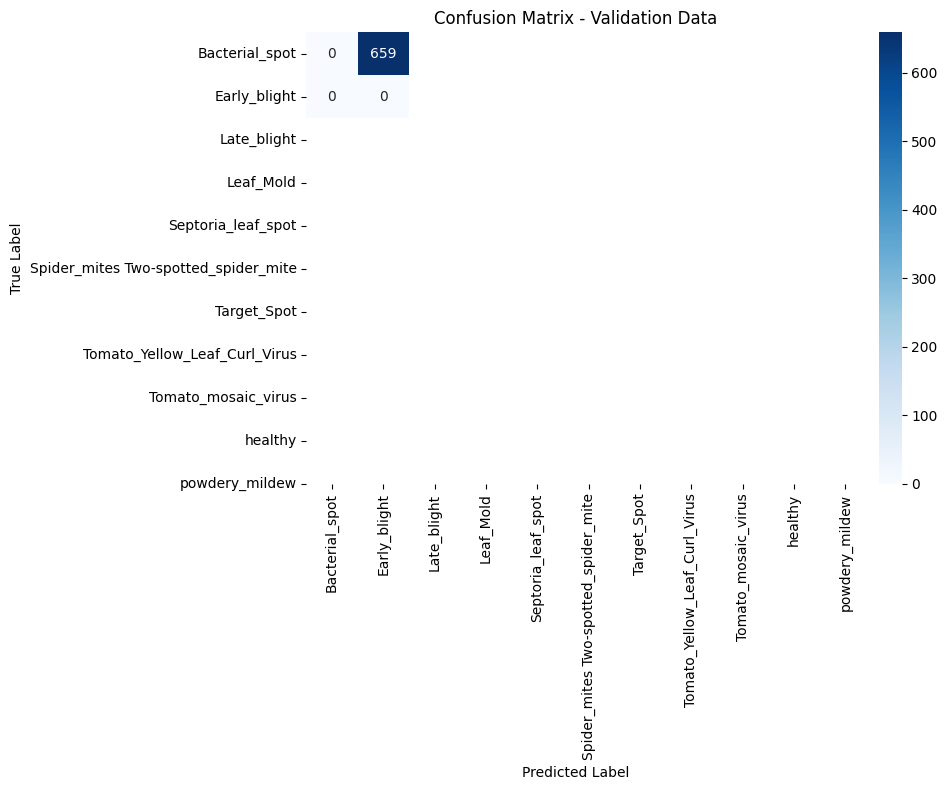

✓ Confusion matrix saved as 'confusion_matrix.png'

DETAILED ANALYSIS BY CLASS
Bacterial_spot      : 0.0000 (0.00%) - 659 samples

SAMPLE PREDICTIONS

Bacterial_spot:
  ✗ True: Bacterial_spot       | Pred: Late_blight          | Confidence: 0.1150
  ✗ True: Bacterial_spot       | Pred: Late_blight          | Confidence: 0.1150
  ✗ True: Bacterial_spot       | Pred: Late_blight          | Confidence: 0.1150

PREDICTION CONFIDENCE STATISTICS
Mean Confidence: 0.1150
Min Confidence:  0.1150
Max Confidence:  0.1150
Std Deviation:   0.0000


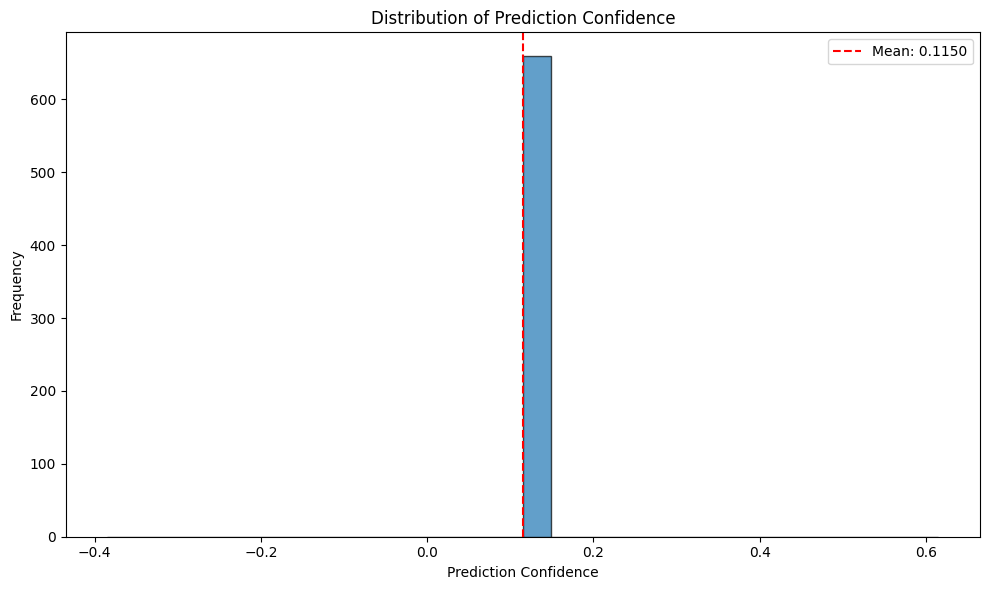

✓ Confidence distribution saved as 'confidence_distribution.png'

LOW CONFIDENCE PREDICTIONS (< 0.7)
Total: 659 out of 659 (100.00%)

Sample low confidence predictions:
  File: BS_(105).jpg
  True: Bacterial_spot | Pred: Late_blight | Confidence: 0.1150

  File: Bs58_mirror_vertical.jpg
  True: Bacterial_spot | Pred: Late_blight | Confidence: 0.1150

  File: 6d672985-36f0-48ad-b956-b1378d63c980___GCREC_Bact.Sp 6052.JPG
  True: Bacterial_spot | Pred: Late_blight | Confidence: 0.1150

  File: b19191da-a846-4e30-85b2-a028e1d85376___UF.GRC_BS_Lab Leaf 8635.JPG
  True: Bacterial_spot | Pred: Late_blight | Confidence: 0.1150

  File: BS_(187).jpg
  True: Bacterial_spot | Pred: Late_blight | Confidence: 0.1150

  File: 268422eb-2e4a-433b-bad2-d5e63a5e765d___GCREC_Bact.Sp 3466.JPG
  True: Bacterial_spot | Pred: Late_blight | Confidence: 0.1150

  File: Bs74_change_270.jpg
  True: Bacterial_spot | Pred: Late_blight | Confidence: 0.1150

  File: 0809f630-10f6-48b4-9aa2-6c08852aa83a___GCREC_Bact.

In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ===== CONFIGURATION =====
IMAGE_SIZE = 224
BATCH_SIZE = 16
MODEL_PATH = '/kaggle/working/best_model.h5'  # Path to your trained model
VALIDATION_DATASET_PATH = '/kaggle/input/tomato/valid'  # Your validation folder

# ===== 1. LOAD TRAINED MODEL =====
print("Loading trained model...")
model = keras.models.load_model(MODEL_PATH)
print("✓ Model loaded successfully!\n")

# ===== 2. SAFE IMAGE LOADING (Same as training) =====
def load_image_py(filepath):
    """Load image using Python with error handling"""
    import cv2
    import numpy as np
    
    try:
        img = cv2.imread(filepath)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img.astype(np.uint8)
    except:
        pass
    
    try:
        from PIL import Image
        img = Image.open(filepath).convert('RGB')
        return np.array(img, dtype=np.uint8)
    except:
        pass
    
    return np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)

def safe_load_image(filepath):
    """TF wrapper for Python image loading"""
    image = tf.py_function(
        func=load_image_py,
        inp=[filepath],
        Tout=tf.uint8
    )
    image.set_shape([None, None, 3])
    return image

def preprocess_image(image):
    """Resize and normalize"""
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# ===== 3. CREATE VALIDATION DATASET =====
def create_validation_dataset(directory, batch_size=BATCH_SIZE):
    """Create validation dataset from directory"""
    
    image_paths = []
    labels = []
    class_names = sorted([d for d in os.listdir(directory) 
                         if os.path.isdir(os.path.join(directory, d))])
    
    print(f"Found classes: {class_names}\n")
    
    # Build list of image paths and labels
    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        count = 0
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_idx)
                count += 1
        print(f"  {class_name}: {count} images")
    
    print(f"\nTotal validation images: {len(image_paths)}\n")
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Map with safe loading and preprocessing
    dataset = dataset.map(
        lambda x, y: (preprocess_image(safe_load_image(x)), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Filter invalid images
    def is_valid_image(x, y):
        return tf.reduce_max(x) > 0.01 or tf.random.uniform([]) > 0.9
    
    dataset = dataset.filter(is_valid_image)
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset, class_names, image_paths, labels

# Load validation data
val_dataset, val_class_names, image_paths, true_labels = create_validation_dataset(
    VALIDATION_DATASET_PATH
)

# Get class names from model's training (if available)
# The validation dataset may have fewer classes than training
print(f"Validation classes found: {val_class_names}")
print(f"Number of validation classes: {len(val_class_names)}")
print(f"Training had 11 classes (from model)\n")

# Create a mapping from validation class indices to actual class names
# Since validation only has 2 classes but they're indexed 0, 1
val_class_mapping = {i: name for i, name in enumerate(val_class_names)}

# ===== 4. EVALUATE MODEL =====
print("=" * 60)
print("EVALUATING MODEL ON VALIDATION DATA")
print("=" * 60)

# Get predictions
predictions = model.predict(val_dataset, verbose=1)
predicted_labels_all = np.argmax(predictions, axis=1)  # 0-10 indices from model
predicted_probs = np.max(predictions, axis=1)

# Convert to numpy arrays for easier handling
true_labels = np.array(true_labels[:len(predicted_labels_all)])
predicted_labels = np.array(predicted_labels_all)

# ===== 5. CALCULATE METRICS =====
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\n{'=' * 60}")
print(f"OVERALL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"{'=' * 60}\n")

# Classification Report
print("CLASSIFICATION REPORT:")
print("=" * 60)

# Since predictions are 0-10 but we only have 2 classes in validation,
# we need to filter to only the classes that exist
unique_true = np.unique(true_labels)
unique_pred = np.unique(predicted_labels)

# Get the intersection of true and predicted classes
all_classes = np.unique(np.concatenate([unique_true, unique_pred]))

# Filter to only classes in validation
valid_indices = all_classes < len(val_class_names)
report_labels = all_classes[valid_indices]
report_target_names = [val_class_names[i] for i in report_labels if i < len(val_class_names)]

# Create mask to include only samples with classes in validation
mask = np.array([true_labels[i] < len(val_class_names) for i in range(len(true_labels))])
filtered_true = true_labels[mask]
filtered_pred = predicted_labels[mask]

print(f"Unique true labels in validation: {np.unique(filtered_true)}")
print(f"Unique predicted labels: {np.unique(filtered_pred)}")
print()

print(classification_report(
    filtered_true, 
    filtered_pred,
    labels=report_labels,
    target_names=report_target_names,
    zero_division=0
))

# Confusion Matrix
cm = confusion_matrix(filtered_true, filtered_pred, labels=report_labels)
print("\nCONFUSION MATRIX:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=val_class_names, yticklabels=val_class_names)
plt.title('Confusion Matrix - Validation Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Confusion matrix saved as 'confusion_matrix.png'")

# ===== 7. DETAILED ANALYSIS =====
print("\n" + "=" * 60)
print("DETAILED ANALYSIS BY CLASS")
print("=" * 60)

for idx, class_name in enumerate(val_class_names):
    class_mask = np.array(true_labels) == idx
    if np.sum(class_mask) > 0:
        class_accuracy = accuracy_score(
            np.array(true_labels)[class_mask], 
            predicted_labels[class_mask]
        )
        count = np.sum(class_mask)
        print(f"{class_name:20s}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%) - {count} samples")

# ===== 8. SHOW SAMPLE PREDICTIONS =====
print("\n" + "=" * 60)
print("SAMPLE PREDICTIONS")
print("=" * 60)

# Get a few samples from each class
samples_per_class = 3
for class_idx, class_name in enumerate(val_class_names):
    class_indices = np.where(np.array(true_labels) == class_idx)[0][:samples_per_class]
    
    if len(class_indices) > 0:
        print(f"\n{class_name}:")
        for idx in class_indices:
            true_class = val_class_names[true_labels[idx]]
            pred_class_idx = predicted_labels[idx]
            # Handle case where predicted class might not be in validation set
            if pred_class_idx < len(val_class_names):
                pred_class = val_class_names[pred_class_idx]
            else:
                pred_class = f"Class {pred_class_idx} (not in validation)"
            confidence = predicted_probs[idx]
            status = "✓" if true_class == pred_class else "✗"
            print(f"  {status} True: {true_class:20s} | Pred: {pred_class:20s} | Confidence: {confidence:.4f}")

# ===== 9. CONFIDENCE DISTRIBUTION =====
print("\n" + "=" * 60)
print("PREDICTION CONFIDENCE STATISTICS")
print("=" * 60)
print(f"Mean Confidence: {np.mean(predicted_probs):.4f}")
print(f"Min Confidence:  {np.min(predicted_probs):.4f}")
print(f"Max Confidence:  {np.max(predicted_probs):.4f}")
print(f"Std Deviation:   {np.std(predicted_probs):.4f}")

# Plot confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(predicted_probs, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(predicted_probs), color='red', linestyle='--', 
            label=f'Mean: {np.mean(predicted_probs):.4f}')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.legend()
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Confidence distribution saved as 'confidence_distribution.png'")

# ===== 10. LOW CONFIDENCE PREDICTIONS =====
low_conf_threshold = 0.7
low_conf_indices = np.where(predicted_probs < low_conf_threshold)[0]

print(f"\n" + "=" * 60)
print(f"LOW CONFIDENCE PREDICTIONS (< {low_conf_threshold})")
print("=" * 60)
print(f"Total: {len(low_conf_indices)} out of {len(predicted_labels)} ({len(low_conf_indices)/len(predicted_labels)*100:.2f}%)")

if len(low_conf_indices) > 0:
    print("\nSample low confidence predictions:")
    for idx in low_conf_indices[:10]:
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[predicted_labels[idx]]
        confidence = predicted_probs[idx]
        filepath = image_paths[idx]
        print(f"  File: {os.path.basename(filepath)}")
        print(f"  True: {true_class} | Pred: {pred_class} | Confidence: {confidence:.4f}")
        print()

print("=" * 60)
print("VALIDATION COMPLETE!")
print("=" * 60)